In [24]:
import cv2
from PIL import Image
from  matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
import sys, os, argparse, time

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo


In [36]:
# Checking if cuda supported GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [88]:
os_path = './data/widerface/train/images/'
def get_list_from_filenames(file_path):
    images_paths =[]
    labels,key = [], ""
    with open(label_txt, 'r') as fr:
        test_dataset = fr.read().split("\n")
    for i, each_line in enumerate(test_dataset):
        if(len(each_line)>0 and each_line[0] == '#'):
            images_paths.append(each_line[2:])
            key = each_line[2:]
        else:
            if each_line!='':
                labels.append((key,np.array(each_line.split()).astype('float32'))) 
    return images_paths,labels
images_paths,labels = get_list_from_filenames(os_path)

In [39]:
os_path = './data/widerface/train/images/'
label_txt = os_path[:-7] + 'label.txt'

with open(label_txt, 'r') as fr:
    test_dataset = fr.read().split("\n")
    
images_paths = []
labels = []
for i, each_line in enumerate(test_dataset):
    if(len(each_line)>0 and each_line[0] == '#'):
        images_paths.append(each_line[2:])
        labels.append([])
    else:
        arr = np.array(each_line.split()).astype('float32') if each_line!='' else []
        labels[len(labels)-1].append(arr)
print(len(images_paths))
print(len(labels))

12852
12852


In [40]:
train_image_paths, valid_image_paths, train_labels, valid_labels = train_test_split(images_paths, labels, test_size=0.7)
test_image_paths, valid_image_paths, test_labels, valid_labels = train_test_split(valid_image_paths, valid_labels, test_size=0.4)
print("Train size: {}".format(len(train_image_paths)))
print("Test size: {}".format(len(test_image_paths)))
print("Validation size: {}".format(len(valid_image_paths)))

Train size: 3855
Test size: 5398
Validation size: 3599


In [41]:
labels[3]

[array([ 69.   , 359.   ,  50.   ,  36.   ,  92.232, 391.397,   1.   ,
         94.451, 377.451,   1.   , 103.326, 386.326,   0.   , 109.348,
        388.228,   0.   , 109.348, 377.134,   0.   ,   0.53 ,  -4.   ,
          5.   ,  -1.   ], dtype=float32),
 array([227. , 382. ,  56. ,  43. , 244. , 399. ,   1. , 248. , 418. ,
          1. , 238. , 412. ,   0. , 234. , 405. ,   0. , 237. , 416. ,
          0. ,   0.5, -19. ,  40. ,  -4. ], dtype=float32),
 array([296. , 305. ,  44. ,  26. , 324. , 318. ,   1. , 324. , 330. ,
          1. , 316. , 329. ,   0. , 308. , 320. ,   0. , 307. , 331. ,
          0. ,   0.4,  -5. ,   5. ,   1. ], dtype=float32),
 array([353.   , 280.   ,  40.   ,  36.   , 371.737, 295.464,   1.   ,
        379.116, 302.844,   1.   , 370.464, 304.879,   1.   , 360.54 ,
        306.152,   1.   , 367.665, 312.513,   1.   ,   0.4  , -10.   ,
         48.   ,   5.   ], dtype=float32),
 array([ 8.85000e+02,  3.77000e+02,  6.30000e+01,  4.10000e+01,
         9.19076e+02

In [42]:
def loadImages(image_dataset_names):
    images = []
    for i, img_name in enumerate(image_dataset_names):
        img = cv2.imread(os_path+img_name,cv2.IMREAD_GRAYSCALE)
        # img= np.array(Image.open(os_path+img_name))
        img = np.array(img)
        img = img.astype('float32')
        img /= 255 
        images.append(img)
    return images

train_images = loadImages(train_image_paths)
val_images = loadImages(valid_image_paths)
# test_images = loadImages(test_image_paths)

In [53]:
train_labels[1][0]

array([166.   , 156.   , 102.   , 162.   , 236.768, 225.353,   0.   ,
       251.969, 228.393,   1.   , 265.143, 259.808,   0.   , 212.446,
       277.036,   0.   , 237.781, 282.103,   1.   ,   0.73 ,  -5.   ,
       -53.   ,   5.   ], dtype=float32)

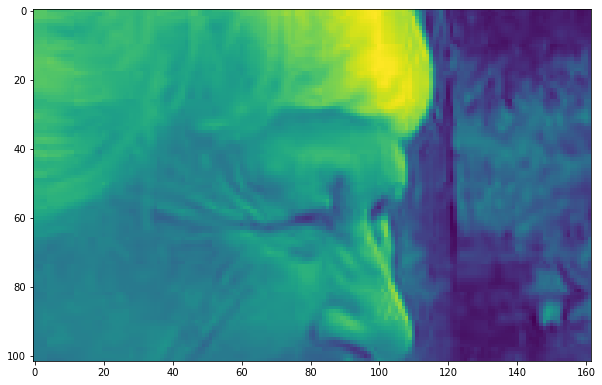

In [64]:
test = np.array(train_images[1])[int(train_labels[1][0][0]):int(train_labels[1][0][0])+int(train_labels[1][0][2]),int(train_labels[1][0][1]):int(train_labels[1][0][1])+int(train_labels[1][0][3])]
plt.figure(figsize=(10,10))
plt.imshow(test)

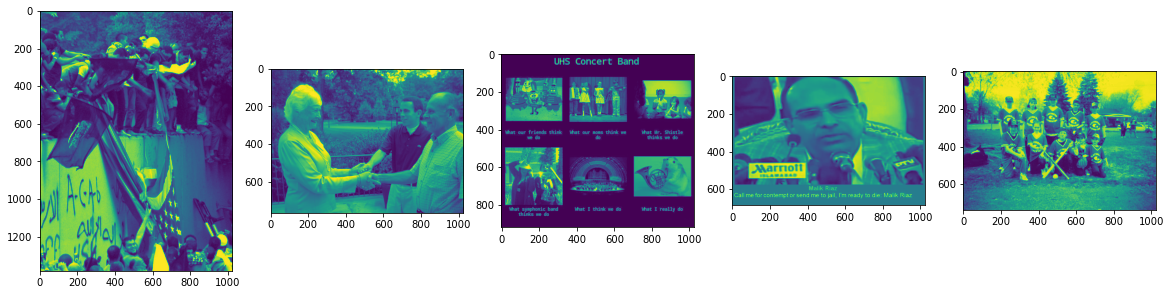

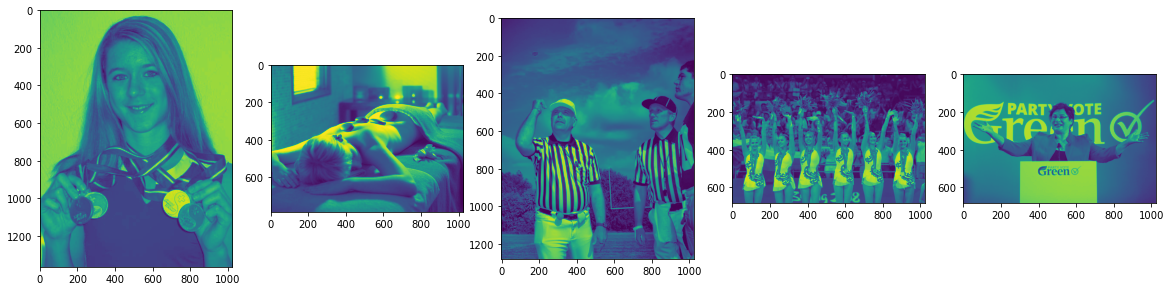

In [65]:
test_folder=r'./data/widerface/train/images/'
def plotTopFive(train_images):
    plt.figure(figsize=(20,20))
    for i in range(5):
        ax=plt.subplot(1,5,i+1)
        plt.imshow(train_images[i])
plotTopFive(train_images)
plotTopFive(val_images)

In [84]:
# Creating customised Image dataset to be used for dataloader
class CustomImageDataset(Dataset):
    def __init__(self, lab, img,dev=device):
        self.img_labels = lab
        self.img = img
        self.device=dev

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        image =transforms.ToTensor()(self.img[idx,:,:][:,:,np.newaxis]) # converts (28,28) img into (28,28,1) img which is converted into a tensor of size(1,28,28)
        label = torch.tensor(self.img_labels[idx],device=self.device).long() # convert label into a long tensor
        data=(image,label)
        return data

In [ ]:
# Creating customised Image dataset to be used for dataloader
class WiderDataset(Dataset):
    def __init__(self, img, labels,transform,,dev=device):
        self.img_labels = lab
        self.img = img
        self.device=dev

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img
        return (image,label)

In [ ]:
# Converting the images and labels into datasets
train_dataset=CustomImageDataset(train_images,train_labels)
validation_dataset=CustomImageDataset(val_images,valid_labels)
test_dataset=CustomImageDataset(test_labels,test_images)

In [85]:
# Converting the images and labels into datasets
train_dataset=CustomImageDataset(train_labels,train_images)
validation_dataset=CustomImageDataset(val_images,valid_labels)
#test_dataset=CustomImageDataset(test_labels,test_images)

In [86]:
# Converting datasets into Dataloader objects (num_workers is set to 0 because setting it to a value >0 is resulting in timeout exception from the os process when device type is cuda and the datasets are custom datasets)
batch=100

loaders = {
    'train' : DataLoader(train_dataset,batch_size=batch, shuffle=True,num_workers=0),
    'test'  : DataLoader(test_dataset,batch_size=batch,shuffle=True,num_workers=0),
    #'validation' : DataLoader(validation_dataset,batch_size=batch,shuffle=True,num_workers=0)
}
print(loaders.keys())
for i in loaders:
    print(loaders[i])

dict_keys(['train', 'test'])


In [70]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import math
import torch.nn.functional as F

class NeuralNet(nn.Module):
    def __init__(self, block, layers, num_bins):
        self.inplanes = 64
        super(NeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc_yaw = nn.Linear(512 * block.expansion, num_bins)
        self.fc_pitch = nn.Linear(512 * block.expansion, num_bins)
        self.fc_roll = nn.Linear(512 * block.expansion, num_bins)

        # Vestigial layer from previous experiments
        self.fc_finetune = nn.Linear(512 * block.expansion + 3, 3)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        pre_yaw = self.fc_yaw(x)
        pre_pitch = self.fc_pitch(x)
        pre_roll = self.fc_roll(x)

        return pre_yaw, pre_pitch, pre_roll

In [71]:
def get_ignored_params(model):
    # Generator function that yields ignored params.
    b = [model.conv1, model.bn1, model.fc_finetune]
    for i in range(len(b)):
        for module_name, module in b[i].named_modules():
            if 'bn' in module_name:
                module.eval()
            for name, param in module.named_parameters():
                yield param
def get_non_ignored_params(model):
    # Generator function that yields params that will be optimized.
    b = [model.layer1, model.layer2, model.layer3, model.layer4]
    for i in range(len(b)):
        for module_name, module in b[i].named_modules():
            if 'bn' in module_name:
                module.eval()
            for name, param in module.named_parameters():
                yield param

def get_fc_params(model):
    # Generator function that yields fc layer params.
    b = [model.fc_yaw, model.fc_pitch, model.fc_roll]
    for i in range(len(b)):
        for module_name, module in b[i].named_modules():
            for name, param in module.named_parameters():
                yield param

def load_filtered_state_dict(model, snapshot):
    # By user apaszke from discuss.pytorch.org
    model_dict = model.state_dict()
    snapshot = {k: v for k, v in snapshot.items() if k in model_dict}
    model_dict.update(snapshot)
    model.load_state_dict(model_dict)

In [72]:
lr=0.001
alpha = 0.001
num_epochs = 1

In [74]:
criterion = nn.CrossEntropyLoss()
model = NeuralNet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], 66)
reg_criterion = nn.MSELoss()
softmax = nn.Softmax()
idx_tensor = [idx for idx in range(66)]
idx_tensor = Variable(torch.FloatTensor(idx_tensor))
optimizer = torch.optim.Adam([{'params': get_ignored_params(model), 'lr': 0},
                                  {'params': get_non_ignored_params(model), 'lr': lr},
                                  {'params': get_fc_params(model), 'lr': lr * 5}],
                                   lr = lr)

In [87]:
print('Ready to train network.')
for epoch in range(num_epochs):
    for i, (images, label) in enumerate(loaders):
        images = Variable(images)

        # Binned labels
        label_yaw = Variable(labels[:,0])
        label_pitch = Variable(labels[:,1])
        label_roll = Variable(labels[:,2])

        # Continuous labels
        label_yaw_cont = Variable(cont_labels[:,0])
        label_pitch_cont = Variable(cont_labels[:,1])
        label_roll_cont = Variable(cont_labels[:,2])

        # Forward pass
        yaw, pitch, roll = model(images)

        # Cross entropy loss
        loss_yaw = criterion(yaw, label_yaw)
        loss_pitch = criterion(pitch, label_pitch)
        loss_roll = criterion(roll, label_roll)

        # MSE loss
        yaw_predicted = softmax(yaw)
        pitch_predicted = softmax(pitch)
        roll_predicted = softmax(roll)

        yaw_predicted = torch.sum(yaw_predicted * idx_tensor, 1) * 3 - 99
        pitch_predicted = torch.sum(pitch_predicted * idx_tensor, 1) * 3 - 99
        roll_predicted = torch.sum(roll_predicted * idx_tensor, 1) * 3 - 99

        loss_reg_yaw = reg_criterion(yaw_predicted, label_yaw_cont)
        loss_reg_pitch = reg_criterion(pitch_predicted, label_pitch_cont)
        loss_reg_roll = reg_criterion(roll_predicted, label_roll_cont)

        # Total loss
        loss_yaw += alpha * loss_reg_yaw
        loss_pitch += alpha * loss_reg_pitch
        loss_roll += alpha * loss_reg_roll

        loss_seq = [loss_yaw, loss_pitch, loss_roll]
        grad_seq = [torch.ones(1) for _ in range(len(loss_seq))]
        optimizer.zero_grad()
        torch.autograd.backward(loss_seq, grad_seq)
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Losses: Yaw %.4f, Pitch %.4f, Roll %.4f'
                   %(epoch+1, num_epochs, i+1, len(pose_dataset)//batch_size, loss_yaw.data[0], loss_pitch.data[0], loss_roll.data[0]))

    # Save models at numbered epochs.
    if epoch % 1 == 0 and epoch < num_epochs:
        print('Taking snapshot...')
        torch.save(model.state_dict(),
        'output/snapshots/' + args.output_string + '_epoch_'+ str(epoch+1) + '.pkl')

Ready to train network.


ValueError: too many values to unpack (expected 2)